In [150]:
import os
import pandas as pd
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import seaborn as sns
from map_boxes import mean_average_precision_for_boxes
from tqdm import tqdm
from pycocotools.coco import COCO

In [207]:
#dataset 파일 경로
dataset_dir = '/opt/ml/dataset/images/'
# train.json 파일 경로
# train_json_path = "/opt/ml/dataset/train.json"
test_json_path = "/opt/ml/dataset/images/test.json"
submission_path = "/opt/ml/sample_submission/+iou_0.97+top300.csv"
# with open(train_json_path, "r") as f:
    # train_data = json.load(f)
with open(test_json_path, "r") as f:
    test_data = json.load(f)

submission = pd.read_csv(submission_path)


In [208]:
def grid_image(image, image_id, bbox_list, class_list, confidence_list):
    colors = ["r", "g", "b", "c", "m", "y", "k", "darkorange", "limegreen", "deepskyblue"] # bbox 색상 리스트
    classes_index = ["General trash", "Paper", "Paper pack", "Metal", "Glass","Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
    fig, axes = plt.subplots(3,4, figsize=(14,12))
    axes = axes.flatten()
    for i in range(len(image)):
        bboxes = bbox_list[i]
        classes = class_list[i]
        confidences = confidence_list[i]
        axes[i].imshow(image[i])
        axes[i].axis("off")
        axes[i].set_title("index: "+ str(image_id[i])+", num_bbox: " + str(len(bbox_list[i])))
        for _, (bbox, class_id, confidence) in enumerate(zip(bboxes, classes, confidences)):
            x, y, w, h = bbox
            w, h = int(w), int(h)    
            class_id = int(class_id)    
            # bbox 시각화
            rect = plt.Rectangle((x, y), w, h, linewidth=float(confidence)*5, edgecolor=colors[class_id], facecolor="none")
            axes[i].add_patch(rect)
            # bbox 라벨 시각화
            label = classes_index[class_id]
            # ax.text(x, y-5, label, fontsize=8, color=colors[class_id], fontweight="bold")
            bbox_props = dict(boxstyle="square,pad=0.3", fc=colors[class_id], ec=colors[class_id], lw=0.3)
            # bbox_props = dict(boxstyle="square,pad=0.3", fc=colors[class_id], ec=colors[class_id], lw=confidences)

            # '''
            # fc 속성을 사용하여 글자 배경 색상을 설정하고,
            # ec 속성을 사용하여 상자 테두리 색상을 설정합니다. 
            # lw 속성을 사용하여 상자 테두리 두께를 설정할 수 있습니다.
            # '''
            axes[i].text(x, y-5, label, fontsize=8, color="w", fontweight="bold", bbox=bbox_props)

    return None

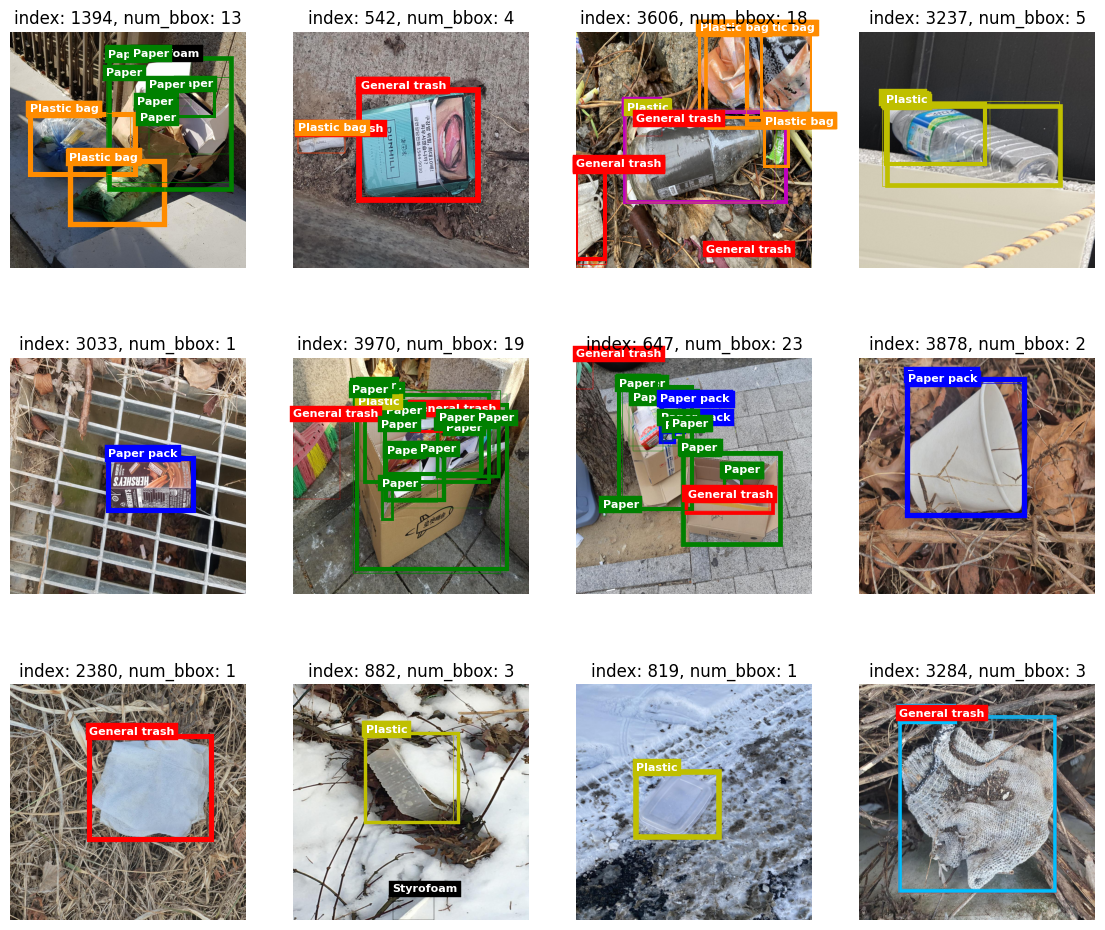

In [209]:
total_bbox=[]
total_class=[]
total_image=[]
total_id=[]
total_confidence=[]
for image_info in random.sample(test_data["images"], 12):       #test image에서 랜덤하게 12개 샘플링
    # 이미지 파일 경로
    image_path = image_info["file_name"]
    # 이미지 불러오기
    image = Image.open(dataset_dir+image_path)
    # 해당 이미지에 대한 annotation 정보 추출
    image_id = image_info["id"]
    bbox_list = []
    class_list = []
    confidence_list=[]
    submission_line = (submission["PredictionString"].iloc[image_id]).split()
    for _ in range(len(submission_line)//6):
        class_list.append(submission_line.pop(0))
        confidence_list.append(submission_line.pop(0))
        bbox_list.append(submission_line.pop(0))
        bbox_list.append(submission_line.pop(0))
        bbox_list.append(submission_line.pop(0))
        bbox_list.append(submission_line.pop(0))
    class_list = np.array(class_list).reshape(-1, 1).astype("int")
    bbox_list = np.array(bbox_list).reshape(-1, 4).astype("float")
    bbox_list[:,2]=bbox_list[:,2]-bbox_list[:,0]
    bbox_list[:,3]=bbox_list[:,3]-bbox_list[:,1]

    total_image.append(image)
    total_id.append(image_id)
    total_bbox.append(bbox_list)
    total_class.append(class_list)
    total_confidence.append(confidence_list)


grid_image(total_image, total_id, total_bbox, total_class, total_confidence)

# bboxes num

<AxesSubplot:title={'center':'bboxes num '}, ylabel='Count'>

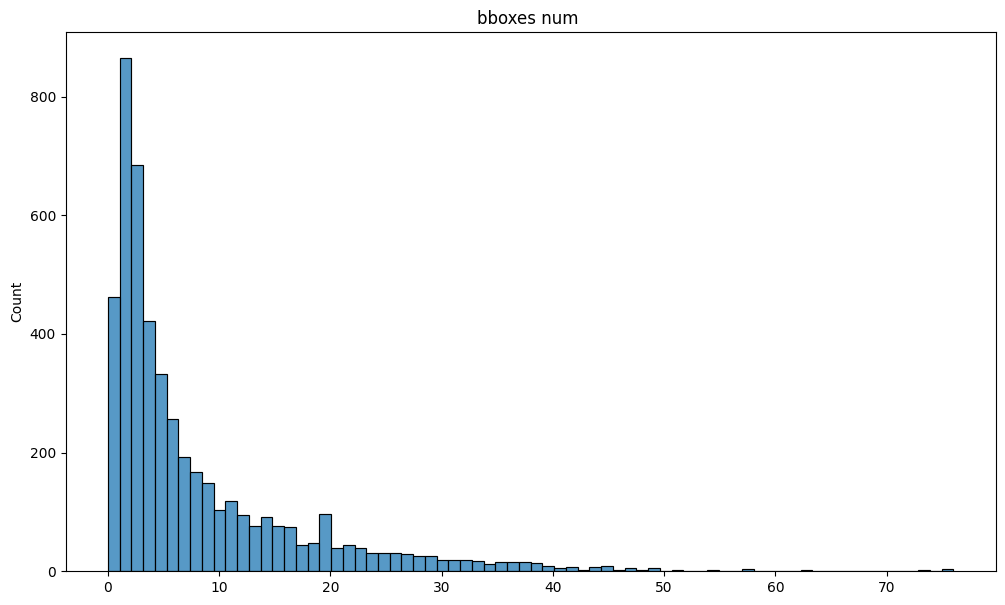

In [210]:
bbox_len = [len(str(i).split())//6 for i in submission["PredictionString"]]
plt.figure(figsize=(12,7))
plt.title("bboxes num ")
sns.histplot(bbox_len)